# Алгоритмы безусловной нелинейной оптимизации. Методы первого и второго порядка

In [1]:
import random
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl

## Data Generation

In [5]:
eps = 1e-3
accuracy = round(m.log(1/eps, 10))

In [6]:
def linear_approx(a, b, x):
    return a * x + b
    
def rational_approx(a, b, x):
    if 1 + x * b != 0:
        return a/(1 + b * x)
    else:
        return 1000000

In [7]:
alpha = random.random()
beta = random.random()
n = 100
x = [k/n for k in range(n + 1)]
y = [alpha * x[k] + beta + random.normalvariate(0, 1) for k in range(n + 1)]

In [8]:
def visualise(predict_a_b, func):
    dpi = 80
    fig = plt.figure(dpi=dpi, figsize=(1024 / dpi, 512 / dpi))
    plt.scatter(x=x, y=y, c='r', label = "data generated") 
    
    for method in predict_a_b.keys():
        print(method, predict_a_b[method])
        y_k = [func(i, predict_a_b[method]["params"][0], predict_a_b[method]["params"][1]) for i in x]
        plt.plot(x, y_k, label=method)
    
    y_k = [alpha * x[k] + beta for k in range(n + 1)]
    plt.plot(x, y_k, label="init line")
    
    plt.title(func.__name__)
    plt.grid(True)
    plt.legend()
    
    fig.set_figwidth(8)
    fig.set_figheight(8)
    plt.show()

## Метод Ньютона

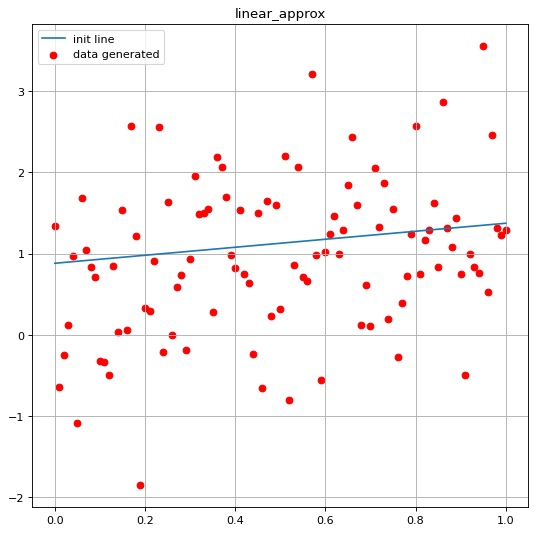

In [9]:
linear_predict_a_b = {}
visualise(linear_predict_a_b, linear_approx)

## Метод Левенберга-Марквардта